<a href="https://colab.research.google.com/github/jannajabel/ECE160-Waste_Classification/blob/main/Upgraded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
!git clone https://github.com/jannajabel/ECE160-Waste_Classification.git

Cloning into 'ECE160-Waste_Classification'...
remote: Enumerating objects: 5485, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 5485 (delta 12), reused 11 (delta 6), pack-reused 5465
Receiving objects: 100% (5485/5485), 210.77 MiB | 13.76 MiB/s, done.
Resolving deltas: 100% (264/264), done.
Checking out files: 100% (5081/5081), done.


In [ ]:
#LOAD DATA
DIR = "/content/ECE160-Waste_Classification/Dataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5077 files belonging to 10 classes.
Using 4570 files for training.
Found 5077 files belonging to 10 classes.
Using 507 files for validation.
['Aluminum', 'Cardboard', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper', 'Plastic', 'Textiles', 'Wood']


In [ ]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 30
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[])

12697600/12683000 [==============================] - 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


36/36 [==============================] - 165s 4s/step - loss: 244.5932 - accuracy: 0.5313 - val_loss: 102.8809 - val_accuracy: 0.7613
Epoch 2/30
36/36 [==============================] - 167s 5s/step - loss: 45.8291 - accuracy: 0.7759 - val_loss: 11.5148 - val_accuracy: 0.6509
Epoch 3/30
36/36 [==============================] - 163s 4s/step - loss: 6.6395 - accuracy: 0.5641 - val_loss: 4.5814 - val_accuracy: 0.4615
Epoch 4/30
36/36 [==============================] - 162s 4s/step - loss: 4.3150 - accuracy: 0.5184 - val_loss: 4.2196 - val_accuracy: 0.4300
Epoch 5/30
36/36 [==============================] - 166s 5s/step - loss: 4.1910 - accuracy: 0.4987 - val_loss: 4.2034 - val_accuracy: 0.4635
Epoch 6/30
36/36 [==============================] - 161s 4s/step - loss: 4.1725 - accuracy: 0.4980 - val_loss: 4.1688 - val_accuracy: 0.4497
Epoch 7/30
36/36 [==============================] - 165s 5s/step - loss: 4.1426 - accuracy: 0.5009 - val_loss: 4.1215 - val_accuracy: 0.4260
Epoch 8/30
36/36 [

In [ ]:
model.save("TRAIN.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

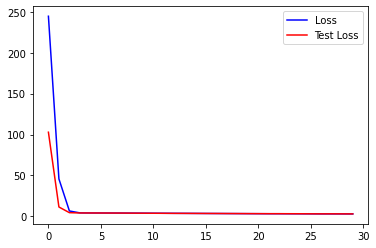

In [ ]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

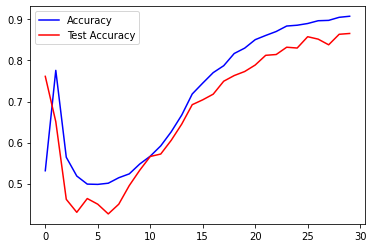

In [ ]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

Text(0, 0.5, 'Loss')

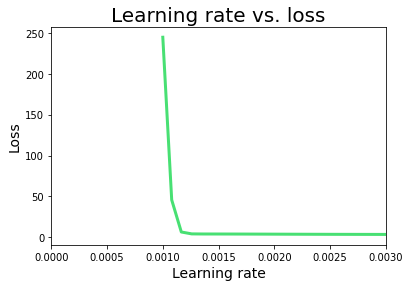

In [ ]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


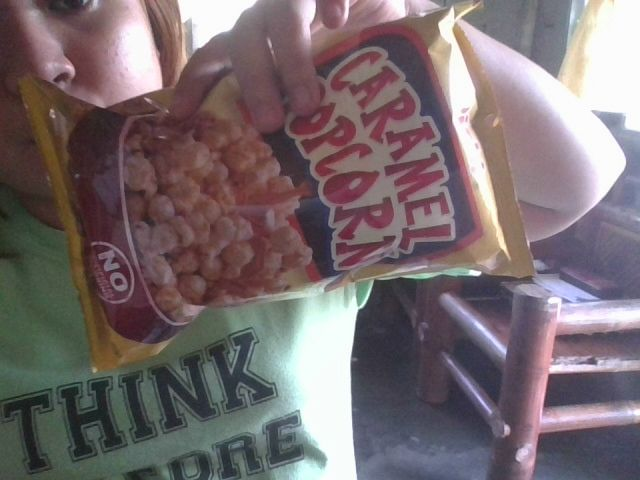

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Found 5077 files belonging to 10 classes.
Using 4570 files for training.
5.01338355243206 
 ['Aluminum', 'Cardboard', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper', 'Plastic', 'Textiles', 'Wood']


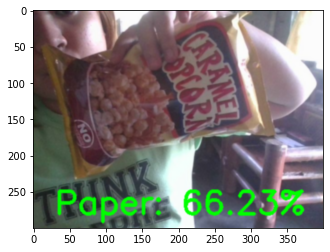

In [ ]:

import cv2
from pylab import *
import imutils



DIR = "/content/ECE160-Waste_Classification/Dataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

dic = train_dataset.class_names
numClasses = len(train_dataset.class_names)


path = "/content/photo.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 
image = cv2.imread(path)
output = image.copy()
output = imutils.resize(output, width=400)


predictions = model.predict(img_array)[0]
i = np.argmax(predictions)
waste_types = ['Aluminum','Cardboard','Carton','Glass','Organic Waste','Other Plastics','Paper','Paper','Plastic','Textiles','Wood']
test_d = '/content/ECE160-Waste_Classification/Dataset' + waste_types[i] + '/'
label = waste_types[i]


text = "{}: {:.2f}%".format(label, predictions[i]* 100)
cv2.putText(output,str (text), (30, 280), cv2.FONT_HERSHEY_SIMPLEX, 1.5,
        (0, 255, 0), 4)

plt.imshow(img)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB), interpolation = 'bicubic')
print(predictions[0]*100, "\n", classes)
#print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

Found 5077 files belonging to 10 classes.
Using 4570 files for training.
5.01338355243206 
 ['Aluminum', 'Cardboard', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper', 'Plastic', 'Textiles', 'Wood']


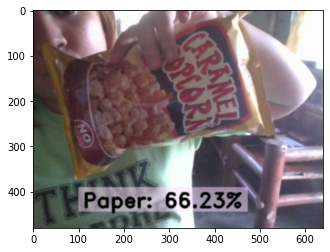

In [74]:
import cv2
from pylab import *
import imutils
import pyshine as ps
import numpy



DIR = "/content/ECE160-Waste_Classification/Dataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

dic = train_dataset.class_names
numClasses = len(train_dataset.class_names)


path = "/content/photo.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 
image = cv2.imread(path)
output = image.copy()
output = imutils.resize(output, width=400)


predictions = model.predict(img_array)[0]
i = np.argmax(predictions)
waste_types = ['Aluminum','Cardboard','Carton','Glass','Organic Waste','Other Plastics','Paper','Paper','Plastic','Textiles','Wood']
test_d = '/content/ECE160-Waste_Classification/Dataset' + waste_types[i] + '/'
label = waste_types[i]



text = "{}: {:.2f}%".format(label, predictions[i]* 100)
#cv2.putText(output,str (text), (30, 280), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(0, 255, 0), 4)
images =  ps.putBText(image,text,text_offset_x = 110,
                      text_offset_y = 400,
                      vspace = 10,
                      hspace = 10,
                      font_scale = 1.5,
                      background_RGB = (255,225,255),
                      text_RGB = (0,0,0),
                      thickness = 3,
                      alpha = 0.5
                      )
#cv2.imshow('output', images)
#plt.imshow(img)
plt.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB), interpolation = 'bicubic')
print(predictions[0]*100, "\n", classes)
#print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")